In [1]:
import numpy as np # MATRIX OPERATIONS
import pandas as pd # EFFICIENT DATA STRUCTURES
import matplotlib.pyplot as plt # GRAPHING AND VISUALIZATIONS
import math # MATHEMATICAL OPERATIONS
import cv2 # IMAGE PROCESSING - OPENCV
from glob import glob # FILE OPERATIONS
import itertools
import os

# KERAS AND SKLEARN MODULES
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger,EarlyStopping
import keras

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# GLOBAL VARIABLES
scale = 70
seed = 7

Using TensorFlow backend.


In [2]:
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop


sns.set(style='white', context='notebook', palette='deep')

In [3]:
path_to_images = 'C:/Users/Q_lab_laptop/Desktop/sohee/plant-seedlings-classification/train/*/*.png'
images = glob(path_to_images)
trainingset = []
traininglabels = []
num = len(images)
count = 1

In [4]:
#READING IMAGES AND RESIZING THEM
for i in images:
    print(str(count)+'/'+str(num),end='\r')
    trainingset.append(cv2.resize(cv2.imread(i),(scale,scale)))
    traininglabels.append(i.split('\\')[-2])
    count=count+1

In [5]:
trainingset = np.asarray(trainingset)
traininglabels = pd.DataFrame(traininglabels)

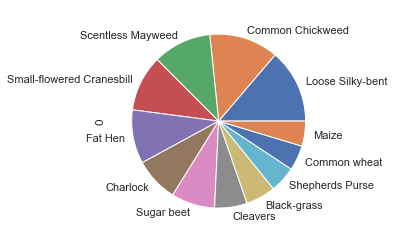

In [6]:
traininglabels[0].value_counts().plot(kind='pie')

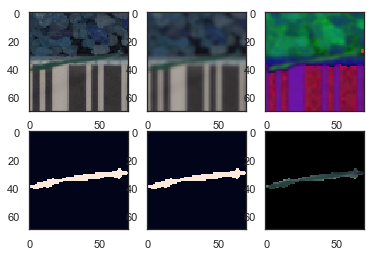

In [7]:
new_train = []
sets = []; getEx = True
for i in trainingset:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    #GREEN PARAMETERS
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    new = np.zeros_like(i,np.uint8)
    new[boolean] = i[boolean]
    new_train.append(new)
    
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i) # ORIGINAL
        plt.subplot(2,3,2);plt.imshow(blurr) # BLURRED
        plt.subplot(2,3,3);plt.imshow(hsv) # HSV CONVERTED
        plt.subplot(2,3,4);plt.imshow(mask) # MASKED
        plt.subplot(2,3,5);plt.imshow(boolean) # BOOLEAN MASKED
        plt.subplot(2,3,6);plt.imshow(new) # NEW PROCESSED IMAGE
        plt.show()
        getEx = False
new_train = np.asarray(new_train)

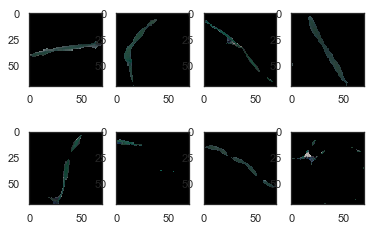

In [8]:
# CLEANED IMAGES example
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(new_train[i])

In [9]:
# Before one-hot-encoding
traininglabels[0]

0       Black-grass
1       Black-grass
2       Black-grass
3       Black-grass
4       Black-grass
5       Black-grass
6       Black-grass
7       Black-grass
8       Black-grass
9       Black-grass
10      Black-grass
11      Black-grass
12      Black-grass
13      Black-grass
14      Black-grass
15      Black-grass
16      Black-grass
17      Black-grass
18      Black-grass
19      Black-grass
20      Black-grass
21      Black-grass
22      Black-grass
23      Black-grass
24      Black-grass
25      Black-grass
26      Black-grass
27      Black-grass
28      Black-grass
29      Black-grass
           ...     
4720     Sugar beet
4721     Sugar beet
4722     Sugar beet
4723     Sugar beet
4724     Sugar beet
4725     Sugar beet
4726     Sugar beet
4727     Sugar beet
4728     Sugar beet
4729     Sugar beet
4730     Sugar beet
4731     Sugar beet
4732     Sugar beet
4733     Sugar beet
4734     Sugar beet
4735     Sugar beet
4736     Sugar beet
4737     Sugar beet
4738     Sugar beet


In [10]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
labels = preprocessing.LabelEncoder()
labels.fit(traininglabels[0])
print('Classes'+str(labels.classes_))
encodedlabels = labels.transform(traininglabels[0])
clearalllabels = np_utils.to_categorical(encodedlabels)
classes = clearalllabels.shape[1]
print("class 갯수: " + str(classes) + "개")

Classes['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
class 갯수: 12개


In [11]:
# After one-hot-encoding
clearalllabels[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [12]:
# Normalize the data
new_train = new_train/255

In [13]:
# Set the random seed
random_seed = 2

In [14]:
# Split the train and the validation set for the fitting
x_train,x_test,y_train,y_test = train_test_split(new_train,clearalllabels,test_size=0.1,random_state=random_seed,stratify=clearalllabels)

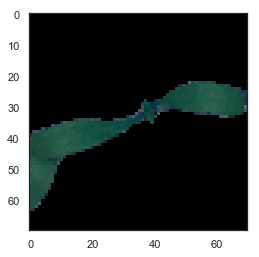

In [15]:
plt.imshow(x_train[5])

In [16]:
np.random.seed(seed)

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(scale, scale, 3), 
                 activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(classes, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
# Define the optimizer and Complie the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
# Set a learning rate annealer, Modelcheckpoint, early stopping callback
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                        patience=3, 
                        verbose=1, 
                        factor=0.4, 
                        min_lr=0.00001)

MODEL_SAVE_FOLDER_PATH = './model/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
  os.mkdir(MODEL_SAVE_FOLDER_PATH)

model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                verbose=1, save_best_only=True, mode='max')
cb_checkpoint_full = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                verbose=1, save_best_only=False, mode='max')
cb_earlystopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=1)

callbacks_list = [cb_checkpoint, learning_rate_reduction, cb_checkpoint_full, cb_earlystopping]

# Fit the model
history = model.fit(x_train,y_train, batch_size=200, epochs = 35, 
                    validation_data = (x_test,y_test), verbose = 2, 
                    
                    callbacks=callbacks_list)

Train on 4275 samples, validate on 475 samples
Epoch 1/35
 - 462s - loss: 2.6089 - acc: 0.2798 - val_loss: 5.7073 - val_acc: 0.3495

Epoch 00001: val_loss improved from -inf to 5.70725, saving model to ./model/01-5.7073.hdf5

Epoch 00001: saving model to ./model/01-5.7073.hdf5
Epoch 2/35
 - 453s - loss: 1.8114 - acc: 0.4449 - val_loss: 2.2258 - val_acc: 0.4232

Epoch 00002: val_loss did not improve from 5.70725

Epoch 00002: saving model to ./model/02-2.2258.hdf5
Epoch 3/35
 - 453s - loss: 1.4780 - acc: 0.5142 - val_loss: 2.3299 - val_acc: 0.4989

Epoch 00003: val_loss did not improve from 5.70725

Epoch 00003: saving model to ./model/03-2.3299.hdf5
Epoch 4/35
 - 456s - loss: 1.1993 - acc: 0.5993 - val_loss: 1.2581 - val_acc: 0.6232

Epoch 00004: val_loss did not improve from 5.70725

Epoch 00004: saving model to ./model/04-1.2581.hdf5
Epoch 5/35
 - 458s - loss: 1.0423 - acc: 0.6501 - val_loss: 1.2745 - val_acc: 0.5705

Epoch 00005: val_loss did not improve from 5.70725

Epoch 00005: s

In [22]:
# Evaluate on train set
print(model.evaluate(x_train, y_train))

# Evaluate on test set
print(model.evaluate(x_test, y_test))

4275/4275 [==============================] - 99s 23ms/step
[1.0319892227301124, 0.6519298245195757]
475/475 [==============================] - 11s 23ms/step
[1.2745482969284057, 0.5705263156639903]


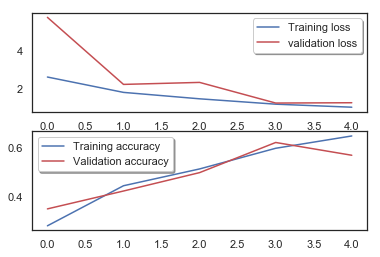

In [23]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [24]:
# Save the model
from keras.models import load_model
model.save('sohee_model.h5')

In [25]:
# Load the model
model.load_weights('C:/Users/Q_lab_laptop/Desktop/sohee/sohee_model.h5')

In [26]:
# Evaluate on train set
print(model.evaluate(x_train, y_train))

# Evaluate on test set
print(model.evaluate(x_test, y_test))

4275/4275 [==============================] - 97s 23ms/step
[1.0319892227301124, 0.6519298245195757]
475/475 [==============================] - 11s 22ms/step
[1.2745482969284057, 0.5705263156639903]


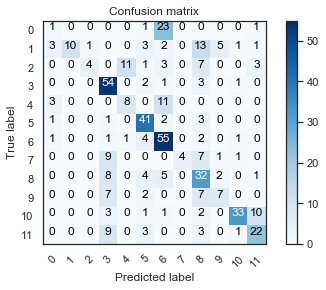

In [27]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(12)) 

In [ ]:
path_to_test = 'C:/Users/Q_lab_laptop/Desktop/sohee/plant-seedlings-classification/test/*.png'
pics = glob(path_to_test)

testimages = []
tests = []
count=1
num = len(pics)

for i in pics:
    print(str(count)+'/'+str(num),end='\r')
    tests.append(i.split('/')[-1])
    testimages.append(cv2.resize(cv2.imread(i),(scale,scale)))
    count = count + 1

testimages = np.asarray(testimages)

In [ ]:
newtestimages = []
sets = []
getEx = True
for i in testimages:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    masking = np.zeros_like(i,np.uint8)
    masking[boolean] = i[boolean]
    newtestimages.append(masking)
    
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i)
        plt.subplot(2,3,2);plt.imshow(blurr)
        plt.subplot(2,3,3);plt.imshow(hsv)
        plt.subplot(2,3,4);plt.imshow(mask)
        plt.subplot(2,3,5);plt.imshow(boolean)
        plt.subplot(2,3,6);plt.imshow(masking)
        plt.show()
        getEx=False

newtestimages = np.asarray(newtestimages)
# OTHER MASKED IMAGES
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(newtestimages[i])

In [ ]:
newtestimages=newtestimages/255
prediction = model.predict(newtestimages)
# PREDICTION TO A CSV FILE
pred = np.argmax(prediction,axis=1)
predStr = labels.classes_[pred]
result = {'file':tests,'species':predStr}
result = pd.DataFrame(result)
result.to_csv("Prediction.csv",index=False)